In [45]:
import pandas as pd
import numpy as np
import wrangle_zillow
import acquire
import explore_zillow
import modeling
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler


In [2]:
df = acquire.get_zillow_data()

In [3]:
df.shape

(52442, 18)

In [4]:
df.isna().sum().sum()

1720

In [5]:
df.shape

(52442, 18)

In [6]:
df.head(1)

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,261.0,53571.0,1286.0,96978.0,1998.0,485713.0,1023282.0,537569.0,11013.72


In [7]:
df = wrangle_zillow.clean_zillow(df)
df.shape

(50913, 17)

In [8]:
df = wrangle_zillow.prepare_zillow(df)

In [9]:
df.head(1).T


parcelid,14297519
logerror,0.0255949
bathroomcnt,3.5
bedroomcnt,4
calculatedfinishedsquarefeet,3100
fips,6059
latitude,33.6349
longitude,-117.869
lotsizesquarefeet,4506
propertylandusetypeid,261
regionidcity,53571


In [10]:
print("LA County Verified: ", df[df.fips==6037]['fips'].count() == df.LA.sum())
print("Orange County Verified: ", df[df.fips==6059]['fips'].count() == df.Orange.sum())
print("Ventura County Verified: ", df[df.fips==6111]['fips'].count() == df.Ventura.sum())

LA County Verified:  True
Orange County Verified:  True
Ventura County Verified:  True


In [11]:
df.shape

(50913, 21)

In [12]:
df.isna().sum().sum()

0

In [21]:
print('We dropped {} rows'.format(52442-df.shape[0]))

We dropped 1529 rows


In [25]:
def create_features(df):
    df['age'] = 2017 - df.yearbuilt
    df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100

    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560

    # bin acres
    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

    # square feet bin
    df['sqft_bin'] = pd.cut(df.calculatedfinishedsquarefeet, 
                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                            labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                       )

    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet


    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                            )


    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


    # update datatypes of binned values to be float
    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})


    # ratio of bathrooms to bedrooms
    df['bath_bed_ratio'] = df.bathroomcnt/df.bedroomcnt

    # 12447 is the ID for city of LA. 
    # I confirmed through sampling and plotting, as well as looking up a few addresses.
    df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)

    return df

In [26]:
df = create_features(df)
df.head().T

parcelid,14297519,17052889,14186244,12177905,12095076
logerror,0.0255949,0.0556191,0.00538285,-0.10341,-0.00101096
bathroomcnt,3.5,1,2,3,3
bedroomcnt,4,2,3,4,4
calculatedfinishedsquarefeet,3100,1465,1243,2376,2962
fips,6059,6111,6059,6037,6037
latitude,33.6349,34.4493,33.8862,34.2452,34.1452
longitude,-117.869,-119.282,-117.823,-118.241,-118.18
lotsizesquarefeet,4506,12647,8432,13038,63000
propertylandusetypeid,261,261,261,261,261
regionidcity,53571,13091,21412,396551,47019


In [29]:
df = wrangle_zillow.remove_outliers()

# Now that the most extreme outliers have been removed, let's look at the summary statistics of each numeric field. 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
logerror,50677.0,0.017964,0.173846,-4.655420,-0.024763,0.006845,0.040386,3.394544e+00
bathroomcnt,50677.0,2.279042,0.969970,1.000000,2.000000,2.000000,3.000000,7.000000e+00
bedroomcnt,50677.0,3.296683,0.911469,1.000000,3.000000,3.000000,4.000000,7.000000e+00
calculatedfinishedsquarefeet,50677.0,1895.668982,929.160139,152.000000,1265.000000,1649.000000,2279.000000,9.848000e+03
fips,50677.0,6049.254395,21.158659,6037.000000,6037.000000,6037.000000,6059.000000,6.111000e+03
latitude,50677.0,34.020331,0.272081,33.340851,33.826838,34.019618,34.185022,3.481877e+01
longitude,50677.0,-118.193653,0.356088,-119.475265,-118.396822,-118.151587,-117.929006,-1.175723e+02
lotsizesquarefeet,50677.0,9754.763463,20163.092932,236.000000,5568.000000,6810.000000,8714.000000,8.623290e+05
propertylandusetypeid,50677.0,261.000000,0.000000,261.000000,261.000000,261.000000,261.000000,2.610000e+02
regionidcity,50677.0,33549.321073,49287.408032,3491.000000,12447.000000,24812.000000,40227.000000,3.965560e+05


In [31]:
df_la = df[df.LA == 1].drop(columns = ['bedroomcnt', 'taxamount', 'taxvaluedollarcnt', 'fips', 
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'yearbuilt', 
                                       'lotsizesquarefeet', 'regionidcity', 'regionidzip', 
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 


In [32]:
print(df_la.shape)

(32667, 18)


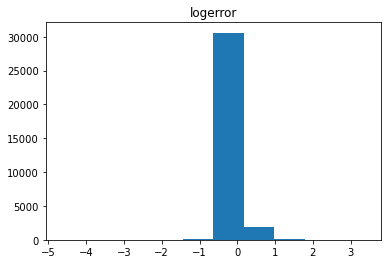

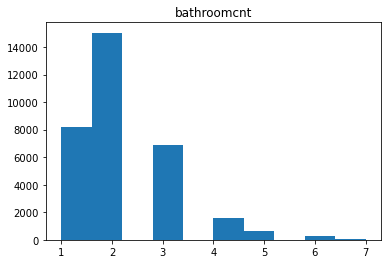

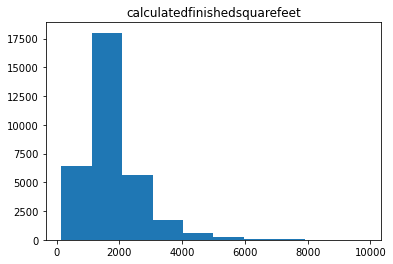

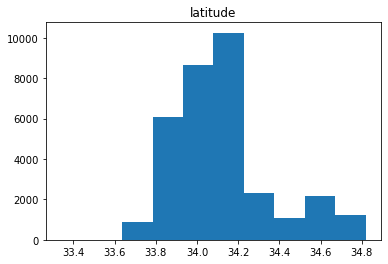

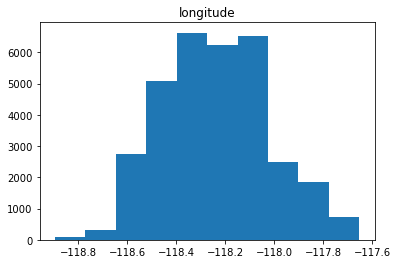

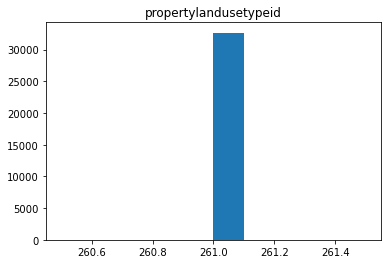

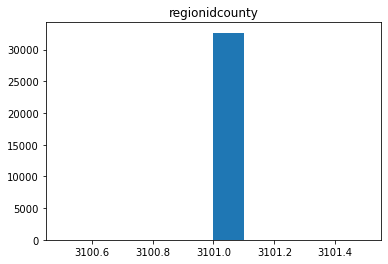

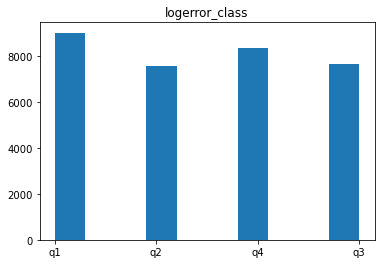

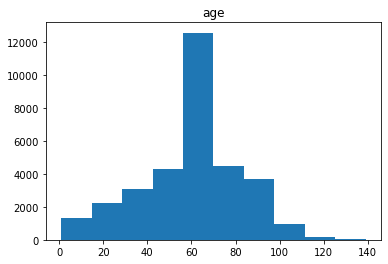

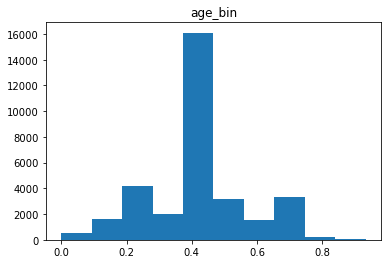

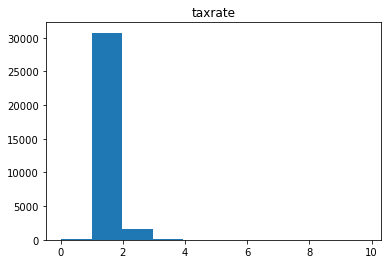

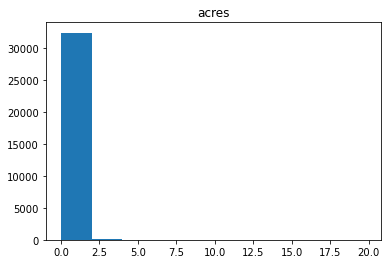

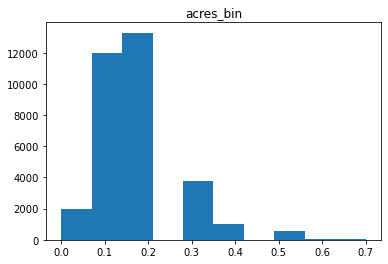

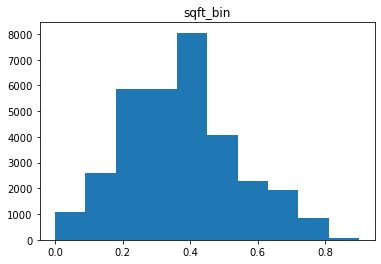

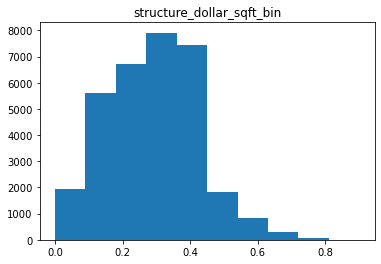

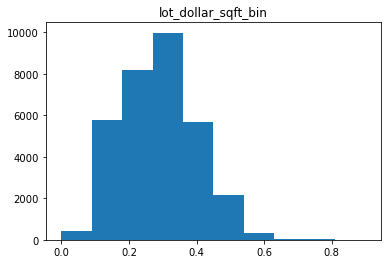

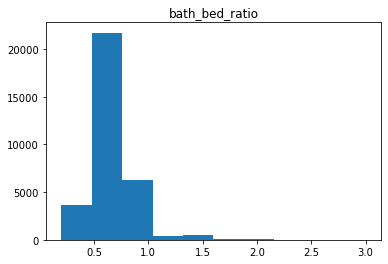

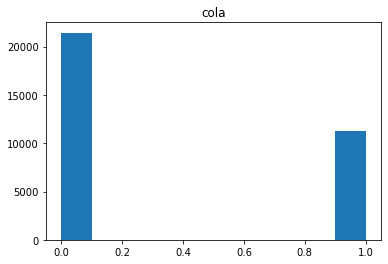

In [33]:
for col in df_la.columns:
    plt.hist(df_la[col])
    plt.title(col)
    plt.show()

linear scalers: latitude, longitude, bathroomcnt, taxrate

no scaling needed: cola, bath_bed_ratio, acres_bin, lot_dollar_sqft_bin, structure_dollar_sqft_bin, sqft_bin, age_bin

In [37]:
partitions = wrangle_zillow.split(df_la, target_var='logerror')


In [38]:
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
partitions[0] = train


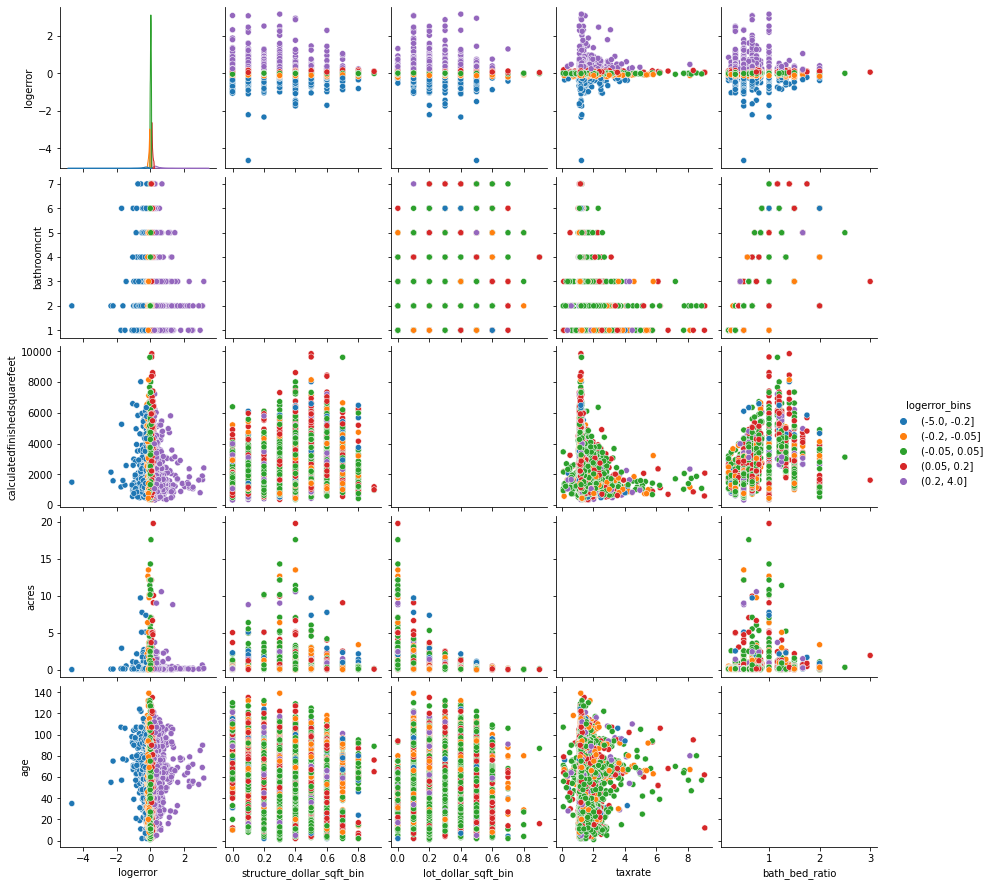

In [39]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'acres', 'age'])

In [40]:
# the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'taxrate']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])

In [41]:
# recall: X[0] is X_train, X[1] is X_validate and X[2] is X_test
X[0].describe()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertylandusetypeid,regionidcounty,age,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,bath_bed_ratio,cola,scaled_latitude,scaled_longitude,scaled_bathroomcnt,scaled_taxrate
count,18293.000000,18293.000000,18293.000000,18293.000000,18293.0,18293.0,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000
mean,2.157656,1778.312469,34.117690,-118.237672,261.0,3101.0,60.488985,0.432158,1.393239,0.240972,0.174919,0.364298,0.274624,0.270404,0.678904,0.345269,0.529866,0.528803,0.192943,0.145798
std,0.992574,884.836252,0.231272,0.215546,0.0,0.0,22.442030,0.151501,0.397296,0.536560,0.100282,0.186127,0.150027,0.124927,0.240164,0.475469,0.157746,0.173980,0.165429,0.044082
min,1.000000,326.000000,33.340851,-118.892812,261.0,3101.0,1.000000,0.000000,0.079206,0.020868,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1190.000000,33.956395,-118.397856,261.0,3101.0,50.000000,0.333000,1.213394,0.130808,0.100000,0.200000,0.200000,0.200000,0.500000,0.000000,0.419850,0.399509,0.000000,0.125843
50%,2.000000,1542.000000,34.091185,-118.240178,261.0,3101.0,63.000000,0.466000,1.263226,0.157966,0.200000,0.400000,0.300000,0.300000,0.666667,0.000000,0.511788,0.526780,0.166667,0.131372
75%,3.000000,2114.000000,34.202862,-118.097054,261.0,3101.0,71.000000,0.533000,1.429257,0.203719,0.200000,0.500000,0.400000,0.400000,0.750000,1.000000,0.587960,0.642304,0.333333,0.149794
max,7.000000,9848.000000,34.806955,-117.653901,261.0,3101.0,139.000000,0.933000,9.091901,19.796350,0.700000,0.900000,0.900000,0.900000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'
k_range = range(2,20)

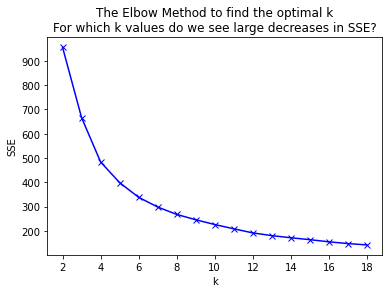

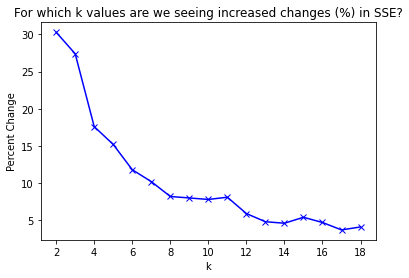

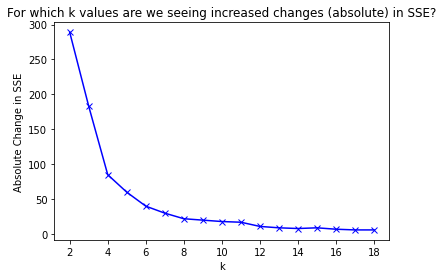

,k,sse,delta,pct_delta
0,2,955.645086,289.0,30.3
1,3,666.195909,183.0,27.4
2,4,483.664696,85.0,17.6
3,5,398.679238,60.0,15.2
4,6,338.265213,40.0,11.8
5,7,298.378733,30.0,10.2
6,8,267.962615,22.0,8.2
7,9,245.996306,20.0,8.0
8,10,226.337094,18.0,7.8
9,11,208.744343,17.0,8.1


In [46]:
find_k(X[0], cluster_vars, k_range)


In [48]:
k = 5
# as reminders: 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'


In [50]:
kmeans = modeling.create_clusters(X[0], k, cluster_vars)

In [52]:
centroid_df = modeling.get_centroids(kmeans, cluster_vars, cluster_name)

In [54]:
X = modeling.assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [67]:
X[0]

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertylandusetypeid,regionidcounty,logerror_class,age,age_bin,taxrate,...,scaled_taxrate,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin,size_cluster,centroid_scaled_bathroomcnt,centroid_sqft_bin,centroid_acres_bin,centroid_bath_bed_ratio
12191915,3.0,1264.0,33.976419,-118.301352,261.0,3101.0,q2,94.0,0.666,1.217797,...,0.126332,2,0.493736,0.499566,0.622930,4,0.142491,0.239249,0.138567,1.000000
10934824,2.0,1300.0,34.120981,-118.346117,261.0,3101.0,q1,58.0,0.400,1.208293,...,0.125277,2,0.493736,0.499566,0.622930,4,0.142491,0.239249,0.138567,1.000000
10861464,5.0,2872.0,34.141910,-118.433056,261.0,3101.0,q4,90.0,0.600,1.242053,...,0.129023,2,0.493736,0.499566,0.622930,4,0.142491,0.239249,0.138567,1.000000
12025313,2.0,1344.0,34.105184,-118.377389,261.0,3101.0,q1,65.0,0.466,1.201040,...,0.124473,2,0.493736,0.499566,0.622930,4,0.142491,0.239249,0.138567,1.000000
12141924,4.0,3730.0,34.125421,-118.030828,261.0,3101.0,q4,28.0,0.200,1.146520,...,0.118423,2,0.493736,0.499566,0.622930,4,0.142491,0.239249,0.138567,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11250988,2.0,1512.0,34.591517,-117.837492,261.0,3101.0,q3,11.0,0.133,1.391856,...,0.145645,3,0.872779,0.617564,0.236948,0,0.004878,0.174629,0.123503,0.424621
12533632,1.0,440.0,33.784256,-118.147204,261.0,3101.0,q1,94.0,0.666,1.273870,...,0.132554,3,0.872779,0.617564,0.236948,0,0.004878,0.174629,0.123503,0.424621
11625192,3.0,2216.0,34.058728,-118.401143,261.0,3101.0,q4,90.0,0.600,1.163356,...,0.120292,3,0.872779,0.617564,0.236948,0,0.004878,0.174629,0.123503,0.424621
12165650,3.0,1407.0,34.175662,-118.138064,261.0,3101.0,q1,79.0,0.533,1.152930,...,0.119135,3,0.872779,0.617564,0.236948,0,0.004878,0.174629,0.123503,0.424621


In [55]:
pd.DataFrame(X[0].groupby(['area_cluster', 'centroid_scaled_latitude', 'centroid_scaled_longitude', 
                           'centroid_age_bin'])['area_cluster'].count())

,,,,area_cluster
area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin,
0,0.486174,0.777381,0.396247,3348
1,0.592608,0.326046,0.376627,4641
2,0.493736,0.499566,0.622930,3823
3,0.872779,0.617564,0.236948,2018
4,0.372783,0.537190,0.441747,4463


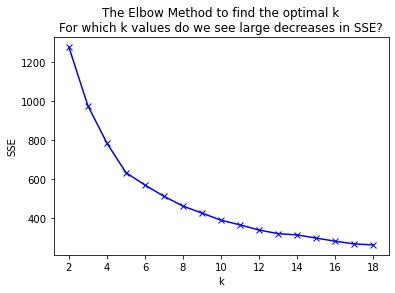

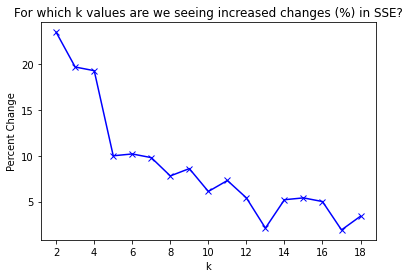

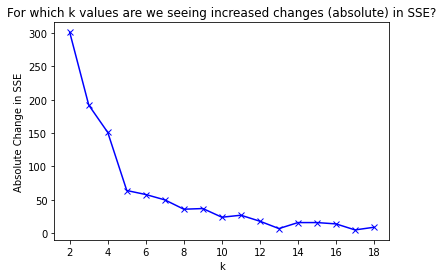

,k,sse,delta,pct_delta
0,2,1278.318261,301.0,23.5
1,3,977.411915,192.0,19.7
2,4,785.232588,151.0,19.3
3,5,633.950710,64.0,10.0
4,6,570.294048,58.0,10.2
5,7,512.136537,50.0,9.8
6,8,462.008565,36.0,7.8
7,9,425.947011,37.0,8.6
8,10,389.421257,24.0,6.1
9,11,365.524968,27.0,7.3


In [56]:
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']
cluster_name = 'size_cluster'
k_range = range(2,20)

find_k(X[0], cluster_vars, k_range)

In [57]:
k=7
cluster_name = 'size_cluster'
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']

# fit kmeans 
kmeans = create_clusters(X[0], k, cluster_vars)

# get centroid values per variable per cluster
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

# get cluster assignments and append those with centroids for each X partition (train, validate, test)
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)

In [79]:
X[0].iloc[:,0:30].T

,12191915,10934824,10861464,12025313,12141924,12673573,12056004,11867700,12434749,12656293,...,10900360,12258236,12967888,10865823,12267248,11250988,12533632,11625192,12165650,12441471
bathroomcnt,3,2,5,2,4,2,2,2,3,3,...,1,2,1,3,1,2,1,3,3,2
calculatedfinishedsquarefeet,1264,1300,2872,1344,3730,1782,1906,1048,2361,1971,...,1134,1377,1061,3264,753,1512,440,2216,1407,1327
latitude,33.9764,34.121,34.1419,34.1052,34.1254,33.8422,34.17,34.0832,33.8255,33.709,...,34.1624,33.9038,34.1592,34.1368,33.9148,34.5915,33.7843,34.0587,34.1757,33.8848
longitude,-118.301,-118.346,-118.433,-118.377,-118.031,-118.374,-118.275,-118.159,-118.095,-118.288,...,-118.384,-118.273,-118.006,-118.483,-118.244,-117.837,-118.147,-118.401,-118.138,-118.178
propertylandusetypeid,261,261,261,261,261,261,261,261,261,261,...,261,261,261,261,261,261,261,261,261,261
regionidcounty,3101,3101,3101,3101,3101,3101,3101,3101,3101,3101,...,3101,3101,3101,3101,3101,3101,3101,3101,3101,3101
logerror_class,q2,q1,q4,q1,q4,q2,q1,q4,q3,q3,...,q4,q3,q4,q3,q1,q3,q1,q4,q1,q2
age,94,58,90,65,28,58,83,89,64,28,...,81,53,89,60,75,11,94,90,79,75
age_bin,0.666,0.4,0.6,0.466,0.2,0.4,0.6,0.6,0.466,0.2,...,0.6,0.4,0.6,0.4,0.533,0.133,0.666,0.6,0.533,0.533
taxrate,1.2178,1.20829,1.24205,1.20104,1.14652,1.1486,1.08923,1.31548,1.22825,1.20244,...,1.20064,1.40791,1.8577,1.22141,2.02531,1.39186,1.27387,1.16336,1.15293,1.21649


In [80]:
X_train = X[0].iloc[:,0:30]

In [74]:
X_train

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertylandusetypeid,regionidcounty,logerror_class,age,age_bin,taxrate,...,scaled_longitude,scaled_bathroomcnt,scaled_taxrate,area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin,size_cluster,centroid_scaled_bathroomcnt,centroid_sqft_bin
12191915,3.0,1264.0,33.976419,-118.301352,261.0,3101.0,q2,94.0,0.666,1.217797,...,0.477403,0.333333,0.126332,2,0.493736,0.499566,0.622930,4,0.142491,0.239249
10934824,2.0,1300.0,34.120981,-118.346117,261.0,3101.0,q1,58.0,0.400,1.208293,...,0.441271,0.166667,0.125277,2,0.493736,0.499566,0.622930,4,0.142491,0.239249
10861464,5.0,2872.0,34.141910,-118.433056,261.0,3101.0,q4,90.0,0.600,1.242053,...,0.371097,0.666667,0.129023,2,0.493736,0.499566,0.622930,4,0.142491,0.239249
12025313,2.0,1344.0,34.105184,-118.377389,261.0,3101.0,q1,65.0,0.466,1.201040,...,0.416029,0.166667,0.124473,2,0.493736,0.499566,0.622930,4,0.142491,0.239249
12141924,4.0,3730.0,34.125421,-118.030828,261.0,3101.0,q4,28.0,0.200,1.146520,...,0.695759,0.500000,0.118423,2,0.493736,0.499566,0.622930,4,0.142491,0.239249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11250988,2.0,1512.0,34.591517,-117.837492,261.0,3101.0,q3,11.0,0.133,1.391856,...,0.851813,0.166667,0.145645,3,0.872779,0.617564,0.236948,0,0.004878,0.174629
12533632,1.0,440.0,33.784256,-118.147204,261.0,3101.0,q1,94.0,0.666,1.273870,...,0.601825,0.000000,0.132554,3,0.872779,0.617564,0.236948,0,0.004878,0.174629
11625192,3.0,2216.0,34.058728,-118.401143,261.0,3101.0,q4,90.0,0.600,1.163356,...,0.396856,0.333333,0.120292,3,0.872779,0.617564,0.236948,0,0.004878,0.174629
12165650,3.0,1407.0,34.175662,-118.138064,261.0,3101.0,q1,79.0,0.533,1.152930,...,0.609203,0.333333,0.119135,3,0.872779,0.617564,0.236948,0,0.004878,0.174629


In [81]:
pd.DataFrame(X_train.groupby(['size_cluster', 'centroid_scaled_bathroomcnt', 'centroid_sqft_bin', 'centroid_acres_bin', 'centroid_bath_bed_ratio'])['area_cluster'].count())


,,,,,area_cluster
size_cluster,centroid_scaled_bathroomcnt,centroid_sqft_bin,centroid_acres_bin,centroid_bath_bed_ratio,
0,0.004878,0.174629,0.123503,0.424621,4442
1,0.626228,0.743878,0.297166,1.049738,882
2,0.166784,0.342274,0.168870,0.619892,7125
3,0.333549,0.494621,0.210305,0.999870,1543
4,0.142491,0.239249,0.138567,1.000000,1172
5,0.335695,0.560893,0.223521,0.713149,2823
6,0.450436,0.544444,0.222222,1.511166,306


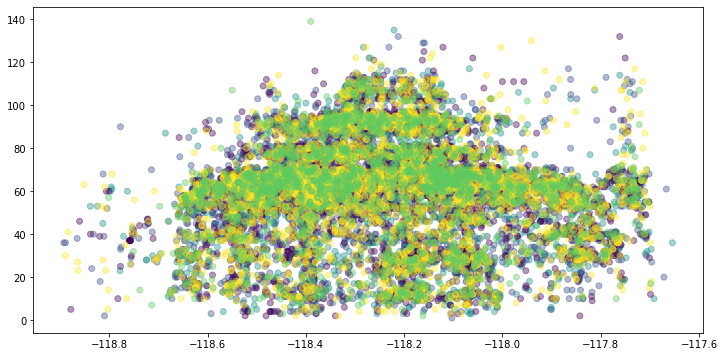

In [82]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=X_train.age, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)

Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

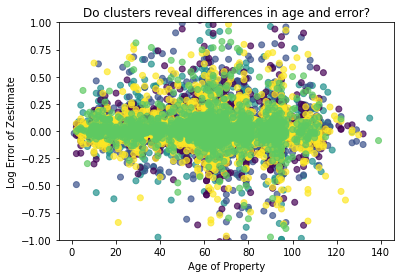

In [83]:
y_train = partitions[-3]

plt.scatter(y=y_train.logerror, x=X_train.age, c=X_train.area_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")

In [35]:
train, validate, test = explore_zillow.train_validate_test_split(df_la, target='logerror', seed=123)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [15]:
train.shape, validate.shape, test.shape

((28511, 21), (12219, 21), (10183, 21))

In [16]:

train.isnull().sum()

logerror                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertylandusetypeid           0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror_class                  0
LA                              0
Orange                          0
Ventura                         0
dtype: int64

In [17]:
object_cols = explore_zillow.get_object_cols(train)
object_cols


[]

In [18]:
numeric_cols = explore_zillow.get_numeric_cols(train, explore_zillow.get_object_cols(train))
numeric_cols

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertylandusetypeid',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror_class',
 'LA',
 'Orange',
 'Ventura']

In [19]:
binary_vars = ['Orange', 'Ventura']
quant_vars = ['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'rawcensustractandblock',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror']
categorical_target = 'logerror_class'
continuous_target = 'logerror'

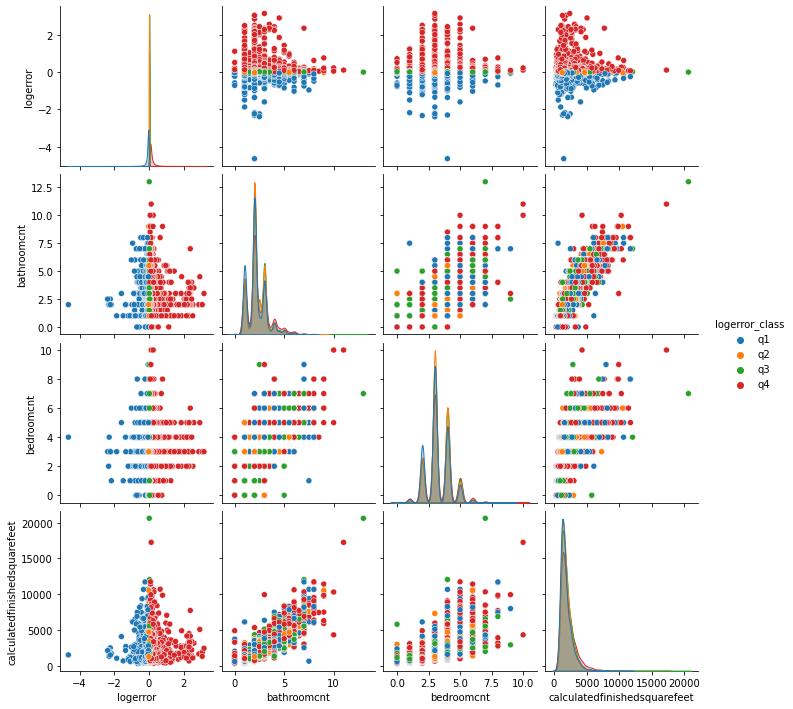

In [20]:
sns.pairplot(train[['logerror','logerror_class', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']], hue='logerror_class')

It appears that the smaller the home, the more the error.  Same for between 2-5 bedrooms and 2-3 bathrooms.

In [23]:
df.head().T

parcelid,14297519,17052889,14186244,12177905,12095076
logerror,0.0255949,0.0556191,0.00538285,-0.10341,-0.00101096
bathroomcnt,3.5,1,2,3,3
bedroomcnt,4,2,3,4,4
calculatedfinishedsquarefeet,3100,1465,1243,2376,2962
fips,6059,6111,6059,6037,6037
latitude,33.6349,34.4493,33.8862,34.2452,34.1452
longitude,-117.869,-119.282,-117.823,-118.241,-118.18
lotsizesquarefeet,4506,12647,8432,13038,63000
propertylandusetypeid,261,261,261,261,261
regionidcity,53571,13091,21412,396551,47019
